In [1]:
# Add root folder to ptyhon path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import scipy.stats as ss
from matplotlib import pyplot as plt

In [12]:
# Set up the failure mode class
from pof.failure_mode import FailureMode

fm = FailureMode(alpha=50, beta=1.5, gamma=10)

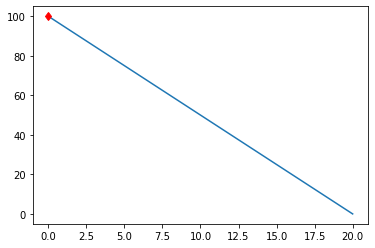

In [13]:
fm.degradation.set_condition_profile()
fm.degradation.plot_condition_profile()

In [14]:
for x in range(0,50):
    fm.sim(1)

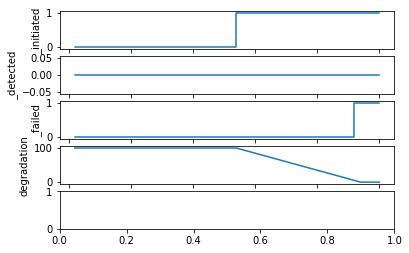

In [15]:
fm.sim_history()

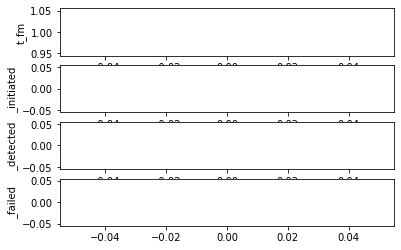

In [7]:
nrows = len(fm._history)
fig, ax = plt.subplots(nrows=4, ncols=1)

row = 0
for field in fm._history:

    ax[row].plot(fm._history[field])
    ax[row].set_ylabel(field)
    row = row + 1

In [8]:
fm._history

{'t_fm': [1], '_initiated': [False], '_detected': [False], '_failed': [False]}